In [1]:
%load_ext autoreload
%autoreload 2
import os
os.sys.path.insert(0, '/home/schirrmr/braindecode/code/braindecode/')

# Amplitude Perturbation Visualization

In this tutorial, we show how to use perturbations of the input amplitudes to learn something about the trained convolutional networks. For more background, see [Deep learning with convolutional neural networks for EEG decoding and visualization](https://arxiv.org/abs/1703.05051), Section A.5.2.

First we will do some cross-subject decoding, again using the [Physiobank EEG Motor Movement/Imagery Dataset](https://www.physionet.org/physiobank/database/eegmmidb/), this time to decode imagined left hand vs. imagined right hand movement.


<div class="alert alert-warning">

This tutorial might be very slow if you are not using a GPU.

</div>

## Load data

In [2]:
%%capture
import mne
import numpy as np
from mne.io import concatenate_raws
from braindecode.datautil.signal_target import SignalAndTarget

# First 50 subjects as train
physionet_paths = [ mne.datasets.eegbci.load_data(sub_id,[4,8,12,]) for sub_id in range(1,51)]
physionet_paths = np.concatenate(physionet_paths)
parts = [mne.io.read_raw_edf(path, preload=True,stim_channel='auto')
         for path in physionet_paths]

raw = concatenate_raws(parts)

picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

events = mne.find_events(raw, shortest_event=0, stim_channel='STI 014')

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epoched = mne.Epochs(raw, events, dict(hands=2, feet=3), tmin=1, tmax=4.1, proj=False, picks=picks,
                baseline=None, preload=True)

# Next 5 subjects as test
physionet_paths_test = [mne.datasets.eegbci.load_data(sub_id,[4,8,12,]) for sub_id in range(51,56)]
physionet_paths_test = np.concatenate(physionet_paths_test)
parts_test = [mne.io.read_raw_edf(path, preload=True,stim_channel='auto')
         for path in physionet_paths_test]
raw_test = concatenate_raws(parts_test)

picks_test = mne.pick_types(raw_test.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')

events_test = mne.find_events(raw_test, shortest_event=0, stim_channel='STI 014')

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epoched_test = mne.Epochs(raw_test, events_test, dict(hands=2, feet=3), tmin=1, tmax=4.1, proj=False, picks=picks_test,
                baseline=None, preload=True)

train_X = (epoched.get_data() * 1e6).astype(np.float32)
train_y = (epoched.events[:,2] - 2).astype(np.int64) #2,3 -> 0,1
test_X = (epoched_test.get_data() * 1e6).astype(np.float32)
test_y = (epoched_test.events[:,2] - 2).astype(np.int64) #2,3 -> 0,1
train_set = SignalAndTarget(train_X, y=train_y)
test_set = SignalAndTarget(test_X, y=test_y)

## Create the model, optimizer, iterator

We use the deep ConvNet from [Deep learning with convolutional neural networks for EEG decoding and visualization](https://arxiv.org/abs/1703.05051) (Section 2.4.2).


In [3]:
from braindecode.models.deep4 import Deep4Net
from torch import nn
from braindecode.torch_ext.util import set_random_seeds
from braindecode.models.util import to_dense_prediction_model

# Set if you want to use GPU
# You can also use torch.cuda.is_available() to determine if cuda is available on your machine.
cuda = True
set_random_seeds(seed=20170629, cuda=cuda)

# This will determine how many crops are processed in parallel
input_time_length = 450
# final_conv_length determines the size of the receptive field of the ConvNet
model = Deep4Net(in_chans=64, n_classes=2, input_time_length=input_time_length,
                 filter_length_3=5, filter_length_4=5,
                 pool_time_stride=2,
                        final_conv_length=1).create_network()
to_dense_prediction_model(model)

if cuda:
    model.cuda()

from torch import optim

optimizer = optim.Adam(model.parameters())

from braindecode.torch_ext.util import np_to_var
# determine output size
test_input = np_to_var(np.ones((2, 64, input_time_length, 1), dtype=np.float32))
if cuda:
    test_input = test_input.cuda()
out = model(test_input)
n_preds_per_input = out.cpu().data.numpy().shape[2]
print("{:d} predictions per input/trial".format(n_preds_per_input))

from braindecode.datautil.iterators import CropsFromTrialsIterator
iterator = CropsFromTrialsIterator(batch_size=32,input_time_length=input_time_length,
                                  n_preds_per_input=n_preds_per_input)

315 predictions per input/trial


## Training loop

In [4]:
from braindecode.torch_ext.util import np_to_var, var_to_np
import torch.nn.functional as F
from numpy.random import RandomState
import torch as th
from braindecode.experiments.monitors import compute_preds_per_trial_for_set
rng = RandomState((2017,6,30))
for i_epoch in range(20):
    print("Epoch {:d}".format(i_epoch))
    print("Train....")
    # Set model to training mode
    model.train()
    for batch_X, batch_y in iterator.get_batches(train_set, shuffle=False):
        net_in = np_to_var(batch_X)
        if cuda:
            net_in = net_in.cuda()
        net_target = np_to_var(batch_y)
        if cuda:
            net_target = net_target.cuda()
        # Remove gradients of last backward pass from all parameters 
        optimizer.zero_grad()
        outputs = model(net_in)
        # Mean predictions across trial
        # Note that this will give identical gradients to computing
        # a per-prediction loss (at least for the combination of log softmax activation 
        # and negative log likelihood loss which we are using here)
        outputs = th.mean(outputs, dim=2, keepdim=False)
        loss = F.nll_loss(outputs, net_target)
        loss.backward()
        optimizer.step()
    
    # Print some statistics each epoch
    model.eval()
    for setname, dataset in (('Train', train_set),('Test', test_set)):
        # Collect all predictions and losses
        all_preds = []
        all_losses = []
        batch_sizes = []
        for batch_X, batch_y in iterator.get_batches(dataset, shuffle=False):
            net_in = np_to_var(batch_X)
            if cuda:
                net_in = net_in.cuda()
            net_target = np_to_var(batch_y)
            if cuda:
                net_target = net_target.cuda()
            outputs = model(net_in)
            all_preds.append(var_to_np(outputs))
            outputs = th.mean(outputs, dim=2, keepdim=False)
            loss = F.nll_loss(outputs, net_target)
            loss = float(var_to_np(loss))
            all_losses.append(loss)
            batch_sizes.append(len(batch_X))
        # Compute mean per-input loss 
        loss = np.mean(np.array(all_losses) * np.array(batch_sizes) /
                       np.mean(batch_sizes))
        print("{:6s} Loss: {:.5f}".format(setname, loss))
        preds_per_trial = compute_preds_per_trial_for_set(all_preds,
                                                          input_time_length,
                                                          dataset)
        # preds per trial are now trials x classes x timesteps/predictions
        # Now mean across timesteps for each trial to get per-trial predictions
        meaned_preds_per_trial = np.array([np.mean(p, axis=1) for p in preds_per_trial])
        predicted_labels = np.argmax(meaned_preds_per_trial, axis=1)
        accuracy = np.mean(predicted_labels == dataset.y)
        print("{:6s} Accuracy: {:.1f}%".format(
            setname, accuracy * 100))


Epoch 0
Train....
Train  Loss: 0.71495
Train  Accuracy: 52.1%
Test   Loss: 0.71683
Test   Accuracy: 48.8%
Epoch 1
Train....
Train  Loss: 0.66374
Train  Accuracy: 61.8%
Test   Loss: 0.64029
Test   Accuracy: 63.8%
Epoch 2
Train....
Train  Loss: 0.64218
Train  Accuracy: 69.2%
Test   Loss: 0.59227
Test   Accuracy: 80.3%
Epoch 3
Train....
Train  Loss: 0.64059
Train  Accuracy: 69.0%
Test   Loss: 0.58956
Test   Accuracy: 84.0%
Epoch 4
Train....
Train  Loss: 0.63735
Train  Accuracy: 70.3%
Test   Loss: 0.58765
Test   Accuracy: 84.0%
Epoch 5
Train....
Train  Loss: 0.62778
Train  Accuracy: 70.2%
Test   Loss: 0.56151
Test   Accuracy: 87.3%
Epoch 6
Train....
Train  Loss: 0.62644
Train  Accuracy: 70.6%
Test   Loss: 0.54780
Test   Accuracy: 89.2%
Epoch 7
Train....
Train  Loss: 0.62846
Train  Accuracy: 69.1%
Test   Loss: 0.54726
Test   Accuracy: 86.4%
Epoch 8
Train....
Train  Loss: 0.62878
Train  Accuracy: 69.9%
Test   Loss: 0.54195
Test   Accuracy: 87.3%
Epoch 9
Train....
Train  Loss: 0.63297
Train  

## Compute correlation: amplitude perturbation - prediction change

First collect all batches and concatenate them into one array of examples:

In [5]:
train_batches = list(iterator.get_batches(train_set, shuffle=False))
train_X_batches = np.concatenate(list(zip(*train_batches))[0])

Next, create a prediction function that that wraps the model prediction function and returns the predictions as numpy arrays.

In [6]:
model.eval();
pred_fn = lambda x: var_to_np(th.mean(model(np_to_var(x).cuda()), dim=2, keepdim=False))

Setup logging and compute the correlations between amplitude perturbations and prediction changes.

In [7]:
from braindecode.visualization.perturbation import compute_amplitude_prediction_correlations
import logging
import sys
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                     level=logging.DEBUG, stream=sys.stdout)

amp_pred_corrs = compute_amplitude_prediction_correlations(pred_fn, train_X_batches, n_iterations=12,
                                         batch_size=30)

2017-09-04 17:27:18,428 INFO : Compute original predictions...
2017-09-04 17:27:31,206 INFO : Iteration 0...
2017-09-04 17:27:31,207 INFO : Sample perturbation...
2017-09-04 17:27:37,230 INFO : Compute new amplitudes...
2017-09-04 17:27:37,853 INFO : Compute new  complex inputs...
2017-09-04 17:27:46,106 INFO : Compute new real inputs...
2017-09-04 17:27:48,971 INFO : Compute new predictions...
2017-09-04 17:27:49,993 INFO : Compute correlation...
2017-09-04 17:27:50,812 INFO : Iteration 1...
2017-09-04 17:27:50,813 INFO : Sample perturbation...
2017-09-04 17:27:54,581 INFO : Compute new amplitudes...
2017-09-04 17:27:55,213 INFO : Compute new  complex inputs...
2017-09-04 17:28:01,076 INFO : Compute new real inputs...
2017-09-04 17:28:03,970 INFO : Compute new predictions...
2017-09-04 17:28:04,972 INFO : Compute correlation...
2017-09-04 17:28:05,598 INFO : Iteration 2...
2017-09-04 17:28:05,599 INFO : Sample perturbation...
2017-09-04 17:28:09,366 INFO : Compute new amplitudes...
20

## Plot correlations

Compute the mean correlations across iterations.

In [8]:
mean_corr = np.mean(amp_pred_corrs, axis=0)

Pick out one frequency range and mean correlations within that frequency range to make a scalp plot.
Here we use the alpha frequency range.

In [9]:

fs = epoched.info['sfreq']
freqs = np.fft.rfftfreq(train_X_batches.shape[2], d=1.0/fs)
start_freq = 7
stop_freq = 14

i_start = np.searchsorted(freqs,start_freq)
i_stop = np.searchsorted(freqs, stop_freq) + 1

freq_corr = np.mean(mean_corr[:,i_start:i_stop], axis=1)

Now get approximate positions of the channels in the 10-20 system.

In [10]:
from braindecode.datasets.sensor_positions import get_channelpos, CHANNEL_10_20_APPROX

ch_names = [s.strip('.') for s in epoched.ch_names]
positions = [get_channelpos(name, CHANNEL_10_20_APPROX) for name in ch_names]
positions = np.array(positions)

### Plot with MNE

In [11]:
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
max_abs_val = np.max(np.abs(freq_corr))

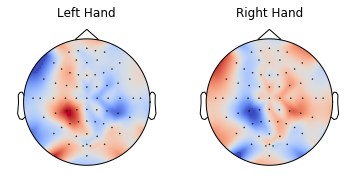

In [12]:
fig, axes = plt.subplots(1, 2)
class_names = ['Left Hand', 'Right Hand']
for i_class in range(2):
    ax = axes[i_class]
    mne.viz.plot_topomap(freq_corr[:,i_class], positions,
                     vmin=-max_abs_val, vmax=max_abs_val, contours=0,
                    cmap=cm.coolwarm, axes=ax, show=False);
    ax.set_title(class_names[i_class])

### Plot with Braindecode

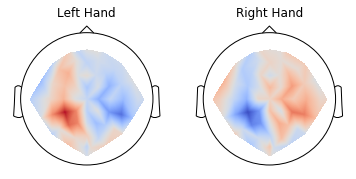

In [13]:
from braindecode.visualization.plot import ax_scalp

fig, axes = plt.subplots(1, 2)
class_names = ['Left Hand', 'Right Hand']
for i_class in range(2):
    ax = axes[i_class]
    ax_scalp(freq_corr[:,i_class], ch_names, chan_pos_list=CHANNEL_10_20_APPROX, cmap=cm.coolwarm,
            vmin=-max_abs_val, vmax=max_abs_val, ax=ax)
    ax.set_title(class_names[i_class])

From these plots we can see the ConvNet clearly learned to use the lateralized response in the alpha band. Note that the positive correlations for the left hand on the left side do not imply an increase of alpha activity for the left hand in the data, see  [Deep learning with convolutional neural networks for EEG decoding and visualization](https://arxiv.org/abs/1703.05051) Result 12 for some notes on interpretability.

## Dataset References


 This dataset was created and contributed to PhysioNet by the developers of the [BCI2000](http://www.schalklab.org/research/bci2000) instrumentation system, which they used in making these recordings. The system is described in:
 
     Schalk, G., McFarland, D.J., Hinterberger, T., Birbaumer, N., Wolpaw, J.R. (2004) BCI2000: A General-Purpose Brain-Computer Interface (BCI) System. IEEE TBME 51(6):1034-1043.

[PhysioBank](https://physionet.org/physiobank/) is a large and growing archive of well-characterized digital recordings of physiologic signals and related data for use by the biomedical research community and further described in:

    Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. (2000) PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23):e215-e220.